<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# Exploratory Data Analysis

This notebook walks you through the steps to exploratory data analysis.

In [1]:
from radiant_mlhub import Collection
import tarfile
import os
from pathlib import Path
import json

import datetime
import rasterio
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedShuffleSplit
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score,balanced_accuracy_score#,plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
df = pd.DataFrame()
for value in ['df_mean_1','df_mean_2']:#['df_median_76_1','df_median_76_2','df_median_76_3','df_median_76_4','df_median_76_5']
    print('Reading Train df:', value)
    #read the pickle file
    picklefile = open(value, 'rb')
    #unpickle the dataframe
    df_tmp = pickle.load(picklefile)
    #close file
    picklefile.close()
    df = pd.concat([df,df_tmp])
    print(len(df_tmp))

Reading Train df: df_mean_1
3603
Reading Train df: df_mean_2
3571


In [3]:
df.reset_index(inplace=True,drop=True)
df

,field_id,20170401_B01,20170401_B02,20170401_B03,20170401_B04,20170401_B05,20170401_B06,20170401_B07,20170401_B08,20170401_B09,...,20171127_B04,20171127_B05,20171127_B06,20171127_B07,20171127_B08,20171127_B09,20171127_B11,20171127_B12,20171127_B8A,label
0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.728477,62.543046,70.079470,75.827815,84.913907,79.523179,113.364238,88.715232,84.841060,8
1,91.0,21.752000,25.448000,34.880000,45.668000,52.108000,56.116000,60.932000,65.100000,70.264000,...,41.936000,48.076000,52.612000,56.956000,62.296000,65.884000,107.628000,90.520000,65.084000,3
2,243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.823529,40.787330,65.063348,73.606335,77.072398,81.416290,88.045249,65.837104,80.013575,4
3,286.0,12.799127,15.448690,22.437773,29.348253,36.932314,45.018559,50.018559,54.330786,58.465066,...,26.365721,37.413755,54.512009,60.182314,65.986900,66.938865,71.457424,48.434498,66.165939,2
4,308.0,21.242424,28.000000,45.696970,63.393939,72.363636,76.393939,81.424242,84.363636,88.454545,...,67.060606,75.969697,79.515152,84.333333,90.515152,88.787879,120.030303,91.060606,91.393939,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,122508.0,17.882353,24.026738,39.647059,61.663102,74.443850,81.604278,89.454545,96.427807,100.459893,...,62.946524,70.994652,75.064171,79.877005,86.518717,87.967914,118.203209,88.754011,87.534759,6
7170,122532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.694613,72.773900,74.878983,78.177542,82.427542,84.045524,118.080804,92.821700,83.049317,7
7171,122534.0,10.294444,13.766667,23.766667,33.611111,42.661111,50.727778,55.472222,59.577778,60.716667,...,39.122222,52.544444,72.127778,79.083333,85.738889,84.433333,95.638889,64.038889,84.761111,4
7172,122585.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.760870,56.510870,80.326087,89.239130,95.054348,91.978261,104.000000,82.456522,93.358696,4


In [4]:
df['label'].value_counts()

4    2133
7    1220
2    1037
1     767
6     684
5     503
3     474
8     209
9     147
Name: label, dtype: int64

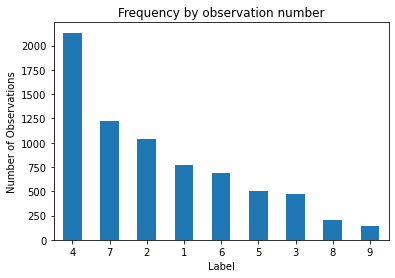

In [5]:
count_labels = pd.value_counts(df['label'], sort = True)
count_labels.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Label")
plt.ylabel("Number of Observations");

In [6]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns].head())

   20170401_B01  20170401_B02  20170401_B03  20170401_B04  20170401_B05  \
0           NaN           NaN           NaN           NaN           NaN   
1     21.752000      25.44800     34.880000     45.668000     52.108000   
2           NaN           NaN           NaN           NaN           NaN   
3     12.799127      15.44869     22.437773     29.348253     36.932314   
4     21.242424      28.00000     45.696970     63.393939     72.363636   

   20170401_B06  20170401_B07  20170401_B08  20170401_B09  20170401_B11  ...  \
0           NaN           NaN           NaN           NaN           NaN  ...   
1     56.116000     60.932000     65.100000     70.264000    107.112000  ...   
2           NaN           NaN           NaN           NaN           NaN  ...   
3     45.018559     50.018559     54.330786     58.465066     68.554585  ...   
4     76.393939     81.424242     84.363636     88.454545    106.666667  ...   

   20171122_B03  20171122_B04  20171122_B05  20171122_B06  20171122_

In [7]:
df[df['label']==3].head(20)

,field_id,20170401_B01,20170401_B02,20170401_B03,20170401_B04,20170401_B05,20170401_B06,20170401_B07,20170401_B08,20170401_B09,...,20171127_B04,20171127_B05,20171127_B06,20171127_B07,20171127_B08,20171127_B09,20171127_B11,20171127_B12,20171127_B8A,label
1,91.0,21.752000,25.448000,34.880000,45.668000,52.108000,56.116000,60.932000,65.100000,70.264000,...,41.936000,48.076000,52.612000,56.956000,62.296000,65.884000,107.628000,90.520000,65.084000,3
7,453.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54.252174,61.017391,64.721739,68.573913,73.452174,73.234783,108.939130,96.365217,72.921739,3
14,705.0,22.708333,27.541667,41.333333,56.541667,62.000000,66.833333,68.708333,72.833333,75.000000,...,64.791667,70.291667,73.458333,76.916667,83.625000,82.041667,115.750000,101.041667,81.791667,3
15,726.0,14.077465,19.267606,36.169014,59.070423,66.535211,69.295775,72.760563,73.450704,74.302817,...,59.802817,66.464789,69.922535,72.950704,75.690141,74.816901,117.816901,98.239437,75.697183,3
20,883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.378049,65.451220,70.792683,76.280488,82.634146,82.158537,118.975610,103.134146,81.329268,3
38,1477.0,20.348168,22.774869,32.272251,44.591623,53.157068,61.410995,67.821990,74.018325,79.518325,...,60.080000,69.510000,78.352500,84.650000,92.437500,95.747500,118.080000,95.930000,94.525000,3
62,2236.0,16.800000,22.600000,36.100000,52.600000,57.800000,60.800000,64.400000,65.800000,65.800000,...,70.000000,75.000000,80.000000,81.200000,89.000000,80.400000,123.200000,110.600000,87.800000,3
81,2790.0,22.067932,24.913472,39.634915,61.564706,70.743074,73.299051,76.615180,75.223909,91.463757,...,71.440987,80.748387,84.702467,88.032258,89.421632,88.546110,136.737761,121.780645,88.654269,3
98,3461.0,12.800000,20.600000,32.000000,40.200000,42.600000,49.400000,53.800000,56.400000,62.400000,...,50.800000,52.600000,69.200000,77.000000,78.800000,92.400000,89.400000,62.600000,81.400000,3
103,3510.0,22.099024,28.302650,40.677824,53.979079,60.818689,64.560669,68.333333,73.213389,101.755927,...,24.227336,36.372385,71.317992,82.513250,87.776848,85.732218,54.931660,39.736402,86.566248,3


In [8]:
#Test
field_id_example = 5274.0
idx_example = df[df['field_id']==field_id_example].index[0]
#df[df['field_id']==field_id_example].loc[:,['20170401_B8A','20170404_B8A','20171127_B8A']]

#### Nota:
- Se observa desbalanceo en el df de los cultivos a estudiar.
- En caso de presencia de nubes (ayudado por la variable CLM) se ha reemplazado los valores originales por valor Nan en las bandas espectrales de Sentinel-2, en diferentes momentos y diferentes parcelas debido a la presencia de nubes/humo.

### Preprocesamiento - Ingeniería de Variables

#### Tratamiento nubes/humo (outlier) bandas Sentinel-2

##### Demostración Gráfica Interpolación nubes/humo (outlier)

In [9]:
cols=[]
cols += (df.filter(regex='._B04').columns).tolist()
banda_ts = pd.DataFrame({
    'Fecha': df[cols].iloc[idx_example].filter(regex='.B04').index, 
    'Banda4':df[cols].iloc[idx_example].filter(regex='.B04').values
})
new = banda_ts['Fecha'].str.split("_", n = 1, expand = True) 
banda_ts['Fecha']= new[0] 

In [10]:
# Convert a datetime
banda_ts['Fecha'] = pd.to_datetime(banda_ts['Fecha'], dayfirst=True)
banda_ts.head()

,Fecha,Banda4
0,2017-04-01,17.435821
1,2017-04-11,26.173134
2,2017-04-21,25.797015
3,2017-05-01,25.600000
4,2017-05-11,NaN


In [11]:
banda_ts['Banda4'].isna().value_counts()/len(banda_ts)*100

False    65.789474
True     34.210526
Name: Banda4, dtype: float64

In [12]:
banda_ts = banda_ts.set_index('Fecha')

,Banda4
Fecha,
2017-04-01,17.435821
2017-04-11,26.173134
2017-04-21,25.797015
2017-05-01,25.600000
2017-05-11,NaN


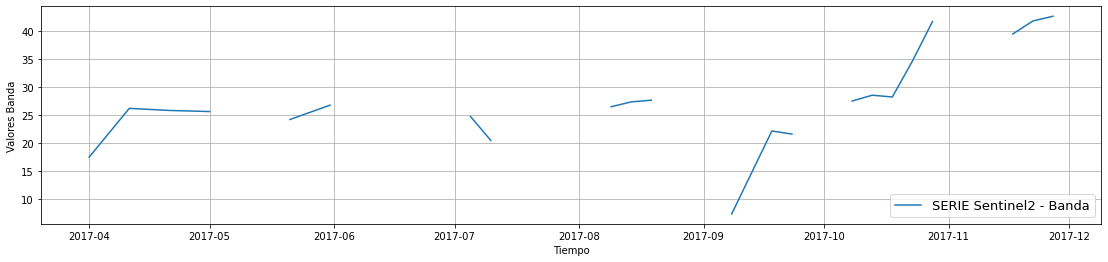

In [13]:
# Finalmente es posible plotear la serie temporal
fig, axes = plt.subplots(figsize=(19,4))
axes.plot(banda_ts.iloc[:,0], label='SERIE Sentinel2 - Banda')
axes.set_xlabel('Tiempo')
axes.set_ylabel('Valores Banda')
axes.grid(True)
axes.legend(loc='lower right', fontsize=13)
banda_ts.iloc[:,0:2].head()

In [14]:
banda_ts['Interp1'] = banda_ts['Banda4'].interpolate(method='linear',limit_direction ='backward')
banda_ts['Interp1']=banda_ts['Interp1'].interpolate(method='linear',limit_direction ='forward')
banda_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2017-04-01 to 2017-11-27
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Banda4   25 non-null     float64
 1   Interp1  38 non-null     float64
dtypes: float64(2)
memory usage: 912.0 bytes


In [15]:
dt1 =pd.DataFrame({'B4_original':banda_ts['Banda4'].values,
                                          'Interp. B4':banda_ts['Interp1'].values,
                                          }, columns=['B4_original','Interp. B4'],index=banda_ts.index)
dt1.head(10)

,B4_original,Interp. B4
Fecha,,
2017-04-01,17.435821,17.435821
2017-04-11,26.173134,26.173134
2017-04-21,25.797015,25.797015
2017-05-01,25.600000,25.600000
2017-05-11,NaN,24.888060
2017-05-21,24.176119,24.176119
2017-05-31,26.749254,26.749254
2017-06-10,NaN,24.713433
2017-06-20,22.677612,22.677612


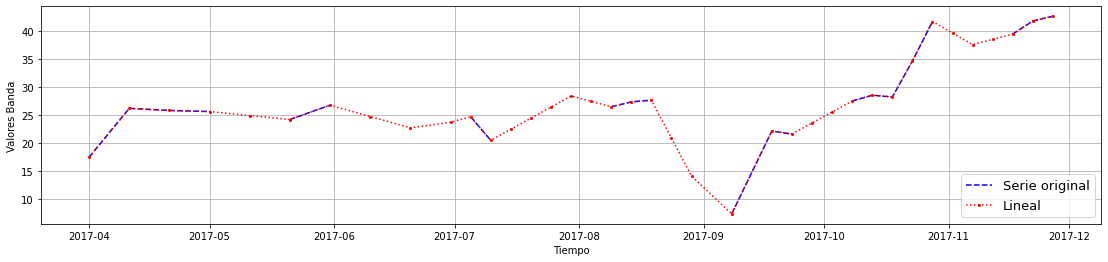

In [16]:
# Finalmente es posible plotear la serie temporal
fig, axes = plt.subplots(figsize=(19,4))
axes.plot(dt1['B4_original'], linestyle='--', ms = 4, color = 'blue', label='Serie original')
axes.plot(dt1['Interp. B4'], marker='.', ms=4, linestyle=':',color='red', label='Lineal')
axes.set_xlabel('Tiempo')
axes.set_ylabel('Valores Banda')
axes.grid(True)
axes.legend(loc='lower right', fontsize=13);

In [17]:
st = dt1['Interp. B4'].copy()

In [18]:
#Suavizado de Hamunyela
for i in np.arange(1, (len(st)-1),1):
    st[i] = np.where(((st[i]-st[i-1] < -0.01*st[i-1]) & 
                     (st[i]-st[i+1] < -0.01*st[i+1])), 
                     (st[i-1]+st[i+1])/2, st[i])

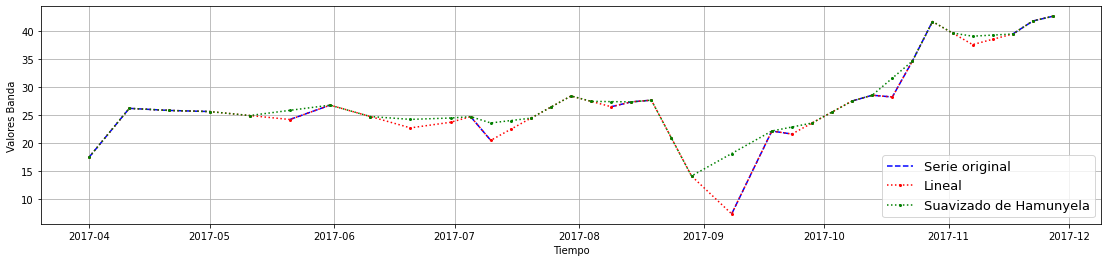

In [19]:
# Finalmente es posible plotear la serie temporal
fig, axes = plt.subplots(figsize=(19,4))
axes.plot(dt1['B4_original'], linestyle='--', ms = 4, color = 'blue', label='Serie original')
axes.plot(dt1['Interp. B4'], marker='.', ms=4, linestyle=':',color='red', label='Lineal')
axes.plot(st, marker='.', ms=4, linestyle=':',color='green', label='Suavizado de Hamunyela')
axes.set_xlabel('Tiempo')
axes.set_ylabel('Valores Banda')
axes.grid(True)
axes.legend(loc='lower right', fontsize=13);

##### Aplicación al DF Interpolación nubes/humo (outlier)

In [20]:
def suavizado(col):
    cols=[]
    cols += (df.filter(regex=col).columns).tolist()
    df_banda = pd.DataFrame(columns = cols)
    df_banda_tmp = pd.DataFrame(columns = cols)
    banda = pd.DataFrame(columns = [col,'{}_I'.format(col)])
    for index, row in  df.iterrows():
        banda[col] = row.filter(regex='._{}'.format(col)).values
        #Interpolación
        banda['{}_I'.format(col)] = banda[col].interpolate(method='linear',limit_direction ='backward')
        banda['{}_I'.format(col)] =  banda['{}_I'.format(col)].interpolate(method='linear',limit_direction ='forward')
        #banda['{}_I'.format(col)] = banda[col].interpolate(method='spline',order=1,limit_direction ='backward')
        #banda['{}_I'.format(col)] =  banda['{}_I'.format(col)].interpolate(method='spline',order=1,limit_direction ='forward')
        # Dejamos los valores de la banda en una variable
        st = banda['{}_I'.format(col)].copy()
        #Suavizado de Hamunyela
        """for i in np.arange(1, (len(st)-1),1):
            st[i] = np.where(((st[i]-st[i-1] < -0.01*st[i-1]) & 
                              (st[i]-st[i+1] < -0.01*st[i+1])), 
                             (st[i-1]+st[i+1])/2, st[i])"""
        df_banda_tmp = pd.DataFrame(data = st.values.reshape(1,len(df_banda_tmp.columns)), columns = df_banda_tmp.columns)
        frames = [df_banda, df_banda_tmp]
        df_banda = pd.concat(frames)
        df_banda=df_banda.reset_index(drop=True)
    return df_banda

In [21]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11', 'B12']
df_final = df.loc[:, ['field_id','label']]
for b in bands:
    df_banda = suavizado(b)
    df_final = pd.merge(df_final, df_banda, right_index=True, left_index=True)

In [22]:
df = df_final.copy()
df = df.reset_index(drop=True)
df

,field_id,label,20170401_B01,20170411_B01,20170421_B01,20170501_B01,20170511_B01,20170521_B01,20170531_B01,20170610_B01,...,20171013_B12,20171018_B12,20171023_B12,20171028_B12,20171102_B12,20171107_B12,20171112_B12,20171117_B12,20171122_B12,20171127_B12
0,4.0,8,25.953642,25.953642,18.728477,16.291391,17.910596,19.529801,24.536424,19.682119,...,55.887417,39.781457,56.900662,57.423841,66.562914,75.701987,81.337748,86.973510,87.844371,88.715232
1,91.0,3,21.752000,20.756000,20.628000,19.848000,18.792000,17.736000,17.788000,15.740000,...,80.744000,69.712000,79.048000,78.560000,82.588000,86.616000,92.116000,88.128000,89.324000,90.520000
2,243.0,4,1.144796,1.144796,1.343891,1.846154,0.393665,6.864253,13.916290,20.968326,...,71.393665,17.312217,69.868778,62.360825,71.067873,70.633484,69.180995,71.533937,68.685520,65.837104
3,286.0,2,12.799127,11.468341,10.575328,10.588792,10.602256,10.615721,10.888646,8.284934,...,45.653930,33.513100,25.922064,43.769651,45.152838,46.536026,47.268559,48.001092,48.217795,48.434498
4,308.0,7,21.242424,15.969697,18.969697,15.676768,12.383838,9.090909,16.393939,12.833333,...,51.939394,36.333333,57.151515,59.121212,61.393939,63.666667,68.606061,73.545455,82.303030,91.060606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,122508.0,6,17.882353,12.812834,16.566845,14.860963,13.155080,11.449198,16.561497,12.622995,...,62.545455,51.497326,68.224599,67.877005,70.949198,74.021390,75.510695,77.000000,82.877005,88.754011
7170,122532.0,7,11.643778,11.643778,17.743551,17.719651,17.695751,17.671851,17.988998,14.575493,...,54.405918,50.094461,60.503414,61.616085,64.430956,67.245827,79.133725,91.021624,91.921662,92.821700
7171,122534.0,4,10.294444,11.822222,10.816667,34.355556,22.438889,10.522222,11.322222,8.565278,...,63.666667,34.300000,65.255556,60.761111,61.269444,61.777778,62.872222,63.966667,37.083333,64.038889
7172,122585.0,4,8.293478,8.293478,7.097826,11.336957,10.956522,10.576087,16.793478,11.945652,...,85.195652,55.554348,83.413043,79.597826,80.788043,81.978261,81.652174,81.326087,81.891304,82.456522


In [23]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [24]:
#Test
#df[df['field_id']==field_id_example].loc[:,['20170401_B8A','20170404_B8A','20171127_B8A']]

#### Cálculo Indices de vegetación

Para el cálculo de los diferentes índices de vegetación me he basado en los siguientes links:

- [Link1](https://acolita.com/lista-de-indices-espectrales-en-sentinel-2-y-landsat/)
- [Link2](https://mappinggis.com/2020/07/los-6-indices-de-vegetacion-para-completar-el-ndvi/#:~:text=Los%20%C3%8Dndices%20de%20Vegetaci%C3%B3n%20son,suelo%2C%20la%20iluminaci%C3%B3n%2C%20etc.)

In [25]:
datetime_variable = 38 #76

- ##### Indice NDVI

In [26]:
# NDVI :(B8A-B04)/(B8A+B04)
B8A_features_col = df.filter(regex='._B8A').columns
B4_features_col = df.filter(regex='._B04').columns
NDVI = []
for i in range(datetime_variable) :
    B8A = '{}'.format(B8A_features_col[i])
    B4 = '{}'.format(B4_features_col[i])
    NDVI.append('{}_NDVI'.format(B8A.split("_")[0]))
    df['{}_NDVI'.format(B8A.split("_")[0])] = (df[B8A]-df[B4])/(df[B8A]+df[B4])

- ##### Indice SLAVI

In [27]:
# SLAVI :(B8A)/(B8A+B12)
#https://www.indexdatabase.de/db/i-single.php?id=89
B12_features_col = df.filter(regex='._B12').columns
SLAVI = []
for i in range(datetime_variable) :
    B8A = '{}'.format(B8A_features_col[i])
    B12 = '{}'.format(B12_features_col[i])
    SLAVI.append('{}_SLAVI'.format(B8A.split("_")[0]))
    df['{}_SLAVI'.format(B8A.split("_")[0])] = (df[B8A])/(df[B8A]+df[B12])

- ##### Indice SAVI

In [28]:
# # SAVI :1.5*(B8A-B04)/(B8A+B04+0.5)
#SAVI = []
#for i in range(datetime_variable) :
#    B8A = '{}'.format(B8A_features_col[i])
#    B4 = '{}'.format(B4_features_col[i])
#    SAVI.append('{}_SAVI'.format(B8A.split("_")[0]))
#    df['{}_SAVI'.format(B8A.split("_")[0])] = (1.5*(df[B8A].divide(10000)-df[B4].divide(10000))/(df[B8A].divide(10000)+df[B4].divide(10000)+0.5)).multiply(10000)

- ##### Indice RECI

In [29]:
#RECI :(B08/B04)-1
#B8_features_col = df.filter(regex='._B08').columns
#RECI = []
#for i in range(datetime_variable) :
#    B8 = '{}'.format(B8_features_col[i])
#    B4 = '{}'.format(B4_features_col[i])
#    RECI.append('{}_RECI'.format(B8.split("_")[0]))
#    df['{}_RECI'.format(B8.split("_")[0])] = (((df[B8]).divide(10000)/(df[B4]).divide(10000))-1).multiply(10000)

- ##### Indice MSI

In [30]:
# MSI :B11/B8A
B11_features_col = df.filter(regex='._B11').columns
MSI = []
for i in range(datetime_variable) :
    B8A = '{}'.format(B8A_features_col[i])
    B11 = '{}'.format(B11_features_col[i])
    MSI.append('{}_MSI'.format(B8A.split("_")[0]))
    df['{}_MSI'.format(B8A.split("_")[0])] = (df[B11])/(df[B8A])

- ##### Indice NDRE

In [31]:
# NDRE :(B09-B05)/(B09+B05)
B9_features_col = df.filter(regex='._B09').columns
B5_features_col = df.filter(regex='._B05').columns
NDRE = []
for i in range(datetime_variable) :
    B9 = '{}'.format(B9_features_col[i])
    B5 = '{}'.format(B5_features_col[i])
    NDRE.append('{}_NDRE'.format(B9.split("_")[0]))
    df['{}_NDRE'.format(B9.split("_")[0])] =  (df[B9]-df[B5])/(df[B9]+df[B5])

In [32]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns])

Empty DataFrame
Columns: []
Index: []


#### Cálculo de Tasseled Cap

La transformación Tasseled Cap es una combinación lineal de información espectral en un conjunto menor de bandas, normalmente tres ejes. A través de estas tres bandas se simplifican los componentes espectrales y permite tratarlas como variables físicas: brillo, verdor y humedad. 
Me he basado en los siguientes links:

- [Link1](https://geoinnova.org/blog-territorio/calculo-de-tasseled-cap-para-imagenes-sentinel-2-con-r/)

- ##### Brightness

In [33]:
# Tasselled Cap - brightness: 0.3510*B02+ 0.3813*B03 + 0.3437*B04+ 0.7196*B08 + 0.2396*B11 + 0.1949*B12
B2_features_col = df.filter(regex='._B02').columns
B3_features_col = df.filter(regex='._B03').columns
B8_features_col = df.filter(regex='._B08').columns
Brightness = []
for i in range(datetime_variable) :
    B2 = '{}'.format(B2_features_col[i])
    B3 = '{}'.format(B3_features_col[i])
    B4 = '{}'.format(B4_features_col[i])
    B8 = '{}'.format(B8_features_col[i])
    B11 = '{}'.format(B11_features_col[i])
    B12 = '{}'.format(B12_features_col[i])
    Brightness.append('{}_Brightness'.format(B2.split("_")[0]))
    df['{}_Brightness'.format(B2.split("_")[0])] = 0.3510*df[B2]+ 0.3813*df[B3] + 0.3437*df[B4]+ 0.7196*df[B8] 
    + 0.2396*df[B11] + 0.1949*df[B12]

- ##### Greeness 

In [34]:
# Tasselled Cap – greenness: (-0.3599* B02) + (-0.3533*B03) +(-0.4734*B04) + 0.6633*B08  +0.0087*B11 + (-0.2856*B12)
Greenness = []
for i in range(datetime_variable) :
    B2 = '{}'.format(B2_features_col[i])
    B3 = '{}'.format(B3_features_col[i])
    B4 = '{}'.format(B4_features_col[i])
    B8 = '{}'.format(B8_features_col[i])
    B11 = '{}'.format(B11_features_col[i])
    B12 = '{}'.format(B12_features_col[i])
    Greenness.append('{}_Greeness'.format(B2.split("_")[0]))
    df['{}_Greeness'.format(B2.split("_")[0])] = (-0.3599*df[B2])+ (-0.3533*df[B3]) + (-0.4734*df[B4])+ 0.6633*df[B8] 
    + 0.0087*df[B11] + (-0.2856*df[B12])

- ##### Wetness

In [35]:
# Tasselled Cap - wetness: (0.2578*B02 + 0.2305*B03 + 0.0883*B04 + 0.1071*B08 + (-0.7611*B11) + (-0.5308*B12))
Wetness = []
for i in range(datetime_variable) :
    B2 = '{}'.format(B2_features_col[i])
    B3 = '{}'.format(B3_features_col[i])
    B4 = '{}'.format(B4_features_col[i])
    B8 = '{}'.format(B8_features_col[i])
    B11 = '{}'.format(B11_features_col[i])
    B12 = '{}'.format(B12_features_col[i])
    Wetness.append('{}_Wetness'.format(B2.split("_")[0]))
    df['{}_Wetness'.format(B2.split("_")[0])] = (0.2578*df[B2]+ 0.2305*df[B3] + 0.0883*df[B4] + 0.1071*df[B8] 
    + (-0.7611*df[B11]) + (-0.5308*df[B12]))

#### Cálculo Estádisticos para cada Indice espectral (PENDIENTE)

Se procede a calcular ciertas medidas estadísticas por cada índice de vegetación calculado a partir del aspecto temporal de los mismos:
   - Desviación standard, 
   - Máximo, 
   - Mínimo y 
   - Media

In [36]:
df = df.reset_index(drop=True)
df

,field_id,label,20170401_B01,20170411_B01,20170421_B01,20170501_B01,20170511_B01,20170521_B01,20170531_B01,20170610_B01,...,20171013_Wetness,20171018_Wetness,20171023_Wetness,20171028_Wetness,20171102_Wetness,20171107_Wetness,20171112_Wetness,20171117_Wetness,20171122_Wetness,20171127_Wetness
0,4.0,8,25.953642,25.953642,18.728477,16.291391,17.910596,19.529801,24.536424,19.682119,...,-64.017491,-47.763876,-63.864977,-65.917326,-77.755807,-89.594289,-95.652043,-101.709797,-102.124805,-102.539812
1,91.0,3,21.752000,20.756000,20.628000,19.848000,18.792000,17.736000,17.788000,15.740000,...,-94.151722,-84.623725,-91.538240,-92.056161,-97.386933,-102.717704,-106.814190,-105.046812,-105.678978,-106.311145
2,243.0,4,1.144796,1.144796,1.343891,1.846154,0.393665,6.864253,13.916290,20.968326,...,-88.324990,-23.118501,-88.251745,-63.588023,-89.739805,-85.956564,-86.806865,-87.530870,-85.046064,-82.561258
3,286.0,2,12.799127,11.468341,10.575328,10.588792,10.602256,10.615721,10.888646,8.284934,...,-57.148951,-44.049082,-31.422432,-55.841396,-57.642242,-59.443088,-60.479749,-61.516410,-61.534691,-61.552973
4,308.0,7,21.242424,15.969697,18.969697,15.676768,12.383838,9.090909,16.393939,12.833333,...,-61.933621,-42.721094,-66.380573,-71.138094,-74.118324,-77.098555,-84.515405,-91.932255,-98.760894,-105.589533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,122508.0,6,17.882353,12.812834,16.566845,14.860963,13.155080,11.449198,16.561497,12.622995,...,-76.498798,-64.667862,-82.010437,-83.497148,-87.353101,-91.209055,-93.866849,-96.524644,-100.460698,-104.396753
7170,122532.0,7,11.643778,11.643778,17.743551,17.719651,17.695751,17.671851,17.988998,14.575493,...,-65.878608,-60.422980,-70.217286,-72.594191,-75.573813,-78.553436,-91.528324,-104.503211,-104.870534,-105.237856
7171,122534.0,4,10.294444,11.822222,10.816667,34.355556,22.438889,10.522222,11.322222,8.565278,...,-79.504275,-49.028632,-81.359017,-77.427872,-77.963383,-78.498894,-79.984453,-81.470013,-48.554729,-82.499479
7172,122585.0,4,8.293478,8.293478,7.097826,11.336957,10.956522,10.576087,16.793478,11.945652,...,-95.611139,-70.040059,-94.802032,-93.071440,-94.035583,-94.999725,-95.229316,-95.458907,-95.665667,-95.872427


In [37]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns])

Empty DataFrame
Columns: []
Index: []


In [38]:
#correlations = df.corr()
#f, ax = plt.subplots(figsize = (20,20))
#sns.heatmap(correlations, annot=True);
#sns.heatmap(df.iloc[:,:100].corr());
#sns.heatmap(df.iloc[:,100:200].corr());

In [39]:
#bands=['B01', 'B02', 'B03', 'B04', 'B05','B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
bands=['B01', 'B03']
df_tmp=df.copy()
for band in bands:
    df_tmp.drop(df_tmp.filter(regex='.'+band).columns, axis=1,inplace=True)
df_tmp.head()

,field_id,label,20170401_B02,20170411_B02,20170421_B02,20170501_B02,20170511_B02,20170521_B02,20170531_B02,20170610_B02,...,20171013_Wetness,20171018_Wetness,20171023_Wetness,20171028_Wetness,20171102_Wetness,20171107_Wetness,20171112_Wetness,20171117_Wetness,20171122_Wetness,20171127_Wetness
0,4.0,8,33.019868,33.019868,28.245033,19.536424,22.321192,25.105960,31.549669,25.165563,...,-64.017491,-47.763876,-63.864977,-65.917326,-77.755807,-89.594289,-95.652043,-101.709797,-102.124805,-102.539812
1,91.0,3,25.448000,24.988000,25.044000,23.392000,21.956000,20.520000,20.932000,18.282000,...,-94.151722,-84.623725,-91.538240,-92.056161,-97.386933,-102.717704,-106.814190,-105.046812,-105.678978,-106.311145
2,243.0,4,2.529412,2.529412,3.076923,3.348416,1.846154,7.497738,13.414027,19.330317,...,-88.324990,-23.118501,-88.251745,-63.588023,-89.739805,-85.956564,-86.806865,-87.530870,-85.046064,-82.561258
3,286.0,2,15.448690,13.709607,13.412664,13.186681,12.960699,12.734716,12.648472,9.753275,...,-57.148951,-44.049082,-31.422432,-55.841396,-57.642242,-59.443088,-60.479749,-61.516410,-61.534691,-61.552973
4,308.0,7,28.000000,23.848485,26.030303,22.414141,18.797980,15.181818,20.424242,15.590909,...,-61.933621,-42.721094,-66.380573,-71.138094,-74.118324,-77.098555,-84.515405,-91.932255,-98.760894,-105.589533


### Creación Modelos

https://relopezbriega.github.io/blog/2016/05/29/machine-learning-con-python-sobreajuste/

In [40]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Matriz Confusión',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [41]:
l_modelo=[]
l_exactitud=[]
l_bexactitud=[]
l_precision=[]
l_exhaustividad=[]
l_f1=[]
#Función que nos permite representar las métricas
def metricas_modelos(modelo,y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    #print(u'Matriz de confusión:')
    #print(cm)

    print("-----Métricas------")
    print(u'Número de muestras clasificadas correctamente:', accuracy_score(y_true, y_pred, normalize=False))
    print(u'Exactitud:', accuracy_score(y_true, y_pred))
    print("Balance Accuracy score:",balanced_accuracy_score(y_true, y_pred))
    print(u'Precision:', precision_score(y_true, y_pred,average='weighted'))
    print(u'Exhaustividad:', recall_score(y_true, y_pred,average='weighted'))
    print(u'F1:', f1_score(y_true, y_pred,average='weighted'))
    print("-------------------")
    print(classification_report(y_true, y_pred))
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=labels)
    
    l_modelo.append(modelo)
    l_exactitud.append(accuracy_score(y_true, y_pred)*100)
    l_bexactitud.append(balanced_accuracy_score(y_true, y_pred)*100)
    l_precision.append(precision_score(y_true, y_pred,average='weighted')*100)
    l_exhaustividad.append(recall_score(y_true, y_pred,average='weighted')*100)
    l_f1.append(f1_score(y_true, y_pred,average='weighted')*100)

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
class PreprocessTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,num_features):
        #cat_features, num_features
        #self.cat_features = cat_features
        self.num_features = num_features
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        # Treat ? workclass as unknown
        #df.loc[df['workclass'] == '?', 'workclass'] = 'Unknown'
        # Too many categories, just convert to US and Non-US
        #df.loc[df['native.country']!='United-States','native.country']='non_usa'
        # Convert columns to categorical
        #for name in self.cat_features:
        #    col = pd.Categorical(df[name])
        #    df[name] = col.codes
        # Normalize numerical features
        scaler = StandardScaler() #MinMaxScaler()
        df[self.num_features] = scaler.fit_transform(df[self.num_features])
        return df

In [43]:
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
  df.drop(['field_id','label'], axis=1),
  df['label'],
  test_size=0.3,
  random_state=42,
  shuffle=True,
  stratify=df['label']
)

In [44]:
X_train.shape

(5021, 722)

#### Reducción Dimensionalidad

- En primer lugar vamos a verificar con cuantas componentes de las 12 bandas nos quedaremos por cada fecha que componen nuestro dataset (38) y que expliquen más del 85% de la varianza de los datos
- Una vez que verifiquemos por cada fecha, conformaremos un datasets para train y otro para test con las nuevas componentes resultantes.
##### Verificamos cuantos componentes pricnipales por cada una de las 38 fechas, explican más del 85% de la varianza

---- Date: 20170401
Suma porcentajes de las 2 PC: 0.9051372552176346
---- Date: 20170411
Suma porcentajes de las 2 PC: 0.9269925251123736
---- Date: 20170421
Suma porcentajes de las 2 PC: 0.9341036271129705
---- Date: 20170501
Suma porcentajes de las 2 PC: 0.9296952621162795
---- Date: 20170511
Suma porcentajes de las 2 PC: 0.9154632006166745
---- Date: 20170521
Suma porcentajes de las 2 PC: 0.9174284964208882
---- Date: 20170531
Suma porcentajes de las 2 PC: 0.9185991783585138
---- Date: 20170610
Suma porcentajes de las 2 PC: 0.8937385383487465
---- Date: 20170620
Suma porcentajes de las 2 PC: 0.8891103516252462
---- Date: 20170630
Suma porcentajes de las 2 PC: 0.8841807214557993
---- Date: 20170705
Suma porcentajes de las 2 PC: 0.9245111954685414
---- Date: 20170710
Suma porcentajes de las 2 PC: 0.9195662321992036
---- Date: 20170715
Suma porcentajes de las 2 PC: 0.8951477782769692
---- Date: 20170720
Suma porcentajes de las 2 PC: 0.9065485969626426
---- Date: 20170725
Suma porcentaj

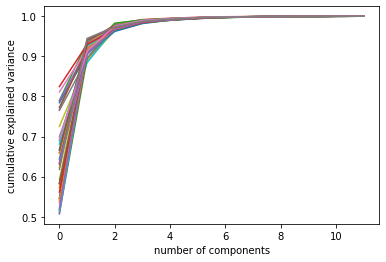

In [45]:
scaler = StandardScaler() #MinMaxScaler()
pca=PCA(n_components=12)
list_date = [value.replace('_B01','') for value in X_train.filter(regex='._B01').columns.values]
bands=['B01', 'B02', 'B03', 'B04', 'B05','B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
list_filter=[]
for value in list_date:
    for band in bands:
        list_filter.append(value+'_'+band)
    X_train_tmp = scaler.fit_transform(X_train[list_filter])
    X_test_tmp = scaler.transform (X_test[list_filter])
    X_train_tmp = pca.fit_transform(X_train_tmp)
    X_test_tmp = pca.transform(X_test_tmp)
    #graficamos el acumulado de varianza explicada en las nuevas dimensiones
    print('---- Date:',value)
    print('Suma porcentajes de las 2 PC:',sum(pca.explained_variance_ratio_[0:2]))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    #plt.show()
    list_filter=[]

##### Conclusión PCA:
Se puede concluir que aplicando un PCA = 2 por cada una de las 38 fechas que conforman nuestro dataset, reducimos la dimensionalidad de las 12 bandas a 2 componentes, explicando más del 85% de la variaza de los datos.

##### Confección de los datasets (train, test) con las componentes resultantes.

In [46]:
X_train_12_to_2 = np.empty((X_train.shape[0], 0))
X_test_12_to_2 = np.empty((X_test.shape[0], 0))
scaler = StandardScaler() #MinMaxScaler()
pca=PCA(n_components=2)
list_date = [value.replace('_B01','') for value in X_train.filter(regex='._B01').columns.values]
bands=['B01', 'B02', 'B03', 'B04', 'B05','B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
list_filter=[]
for value in list_date:
    for band in bands:
        list_filter.append(value+'_'+band)
    X_train_tmp = scaler.fit_transform(X_train[list_filter])
    X_test_tmp = scaler.transform (X_test[list_filter])
    X_train_tmp = pca.fit_transform(X_train_tmp)
    X_test_tmp = pca.transform(X_test_tmp)
    X_train_12_to_2 = np.append(X_train_12_to_2, X_train_tmp, axis=1)
    X_test_12_to_2 = np.append(X_test_12_to_2, X_test_tmp, axis=1)
    list_filter=[]
X_train_12_to_2.shape,X_test_12_to_2.shape

((5021, 76), (2153, 76))

#### Escalado Estándard:

Escalamos/Normalizamos para el resto de variables: índices, Brightness, Greeness y Wetness calculados previamente. Es una buena práctica, para que los valores de las diferentes variables se encuentren en un mismo rango y de esta manera no influya una más que otra al momento de entrenar los modelos propuestos.
Este escalado, utiliza la media y la desviación típica para escalar y es bastante sensible en presencia de los outlier (humo/nubes) identificados. De todos modo ha sido el escalado que me ha dado mejor resultado por eso lo he seleccionado.

In [47]:
list_columns = bands=['NDVI', 'SLAVI', 'MSI', 'NDRE', 'Brightness', 'Greeness', 'Wetness']
list_filter=[X_train.filter(regex='._'+column).columns.values.tolist() for column in list_columns]
list_filter = [item for sublist in list_filter for item in sublist]

In [48]:
scaler = StandardScaler() #MinMaxScaler()
X_train_rest = scaler.fit_transform(X_train[list_filter])
X_test_rest = scaler.transform (X_test[list_filter])
X_train_rest.shape, X_test_rest.shape

((5021, 266), (2153, 266))

In [49]:
X_train = np.append(X_train_rest, X_train_12_to_2, axis=1)
X_test = np.append(X_test_rest, X_test_12_to_2, axis=1)
X_train.shape, X_test.shape

((5021, 342), (2153, 342))

#### Model Random Forest Classifier

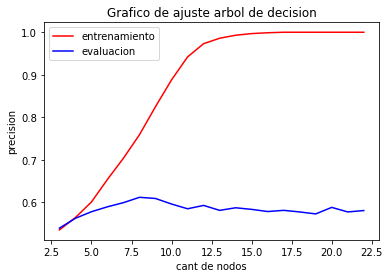

In [50]:
# Grafico de ajuste del árbol de decisión
train_prec =  []
eval_prec = []
max_deep_list = list(range(3, 23))

for deep in max_deep_list:
    rf = DecisionTreeClassifier(criterion='entropy', max_depth=deep)
    rf.fit(X_train, y_train)
    train_prec.append(rf.score(X_train, y_train))
    eval_prec.append(rf.score(X_test, y_test))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='evaluacion')
plt.title('Grafico de ajuste arbol de decision')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

#### Conclusión
El gráfico que acabamos de construir se llama gráfico de ajuste y muestra la precisión del modelo en función de su complejidad. En nuestro ejemplo, podemos ver que el punto con mayor precisión, en los datos de test, lo obtenemos con un nivel de profundidad de aproximadamente 6 nodos; a partir de allí el modelo pierde en generalización y comienza a estar sobreajustado. Por lo tanto utilizaremos el parámetro max_depth = 6 o max_depth = 5.

In [51]:
# We ran a simple hyperparameter tuning for the number of trees, and concluded to use:
n_trees = 200
md = 5

In [52]:
# Fitting the RF model
model_rf = RandomForestClassifier(n_estimators = n_trees, random_state = 0, n_jobs = 3,max_depth=md)
model_rf.fit(X_train, y_train.astype(int))

RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=3, random_state=0)

-----Métricas------
Número de muestras clasificadas correctamente: 3239
Exactitud: 0.6450906193985262
Balance Accuracy score: 0.42732355749888584
Precision: 0.6173304128275958
Exhaustividad: 0.6450906193985262
F1: 0.6009776014168668
-------------------
              precision    recall  f1-score   support

           1       0.47      0.37      0.41       537
           2       0.49      0.69      0.57       726
           3       0.66      0.14      0.22       332
           4       0.82      0.94      0.88      1493
           5       0.45      0.56      0.50       352
           6       0.69      0.24      0.35       478
           7       0.66      0.91      0.77       854
           8       0.00      0.00      0.00       146
           9       0.00      0.00      0.00       103

    accuracy                           0.65      5021
   macro avg       0.47      0.43      0.41      5021
weighted avg       0.62      0.65      0.60      5021



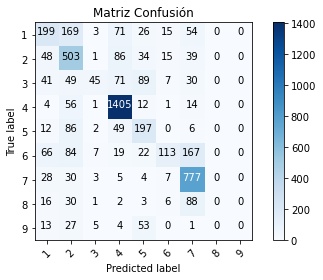

In [53]:
predictions = model_rf.predict(X_train)
metricas_modelos('RF-Train',y_train, predictions, [1,2,3,4,5,6,7,8,9])

In [54]:
# precisión del modelo en datos de entrenamiento.
print("Exactitud entranamiento: {0: .2f}".format(
        model_rf.score(X_train, y_train)))

Exactitud entranamiento:  0.65


-----Métricas------
Número de muestras clasificadas correctamente: 1369
Exactitud: 0.6358569437993498
Balance Accuracy score: 0.41710065601490476
Precision: 0.5877341477080281
Exhaustividad: 0.6358569437993498
F1: 0.5888397995979605
-------------------
              precision    recall  f1-score   support

           1       0.49      0.40      0.44       230
           2       0.49      0.70      0.58       311
           3       0.24      0.04      0.06       142
           4       0.82      0.93      0.87       640
           5       0.43      0.55      0.48       151
           6       0.69      0.25      0.36       206
           7       0.65      0.89      0.75       366
           8       0.00      0.00      0.00        63
           9       0.00      0.00      0.00        44

    accuracy                           0.64      2153
   macro avg       0.42      0.42      0.39      2153
weighted avg       0.59      0.64      0.59      2153



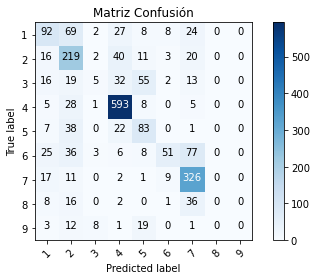

In [55]:
predictions = model_rf.predict(X_test)
metricas_modelos('RF-Test',y_test, predictions, [1,2,3,4,5,6,7,8,9])

In [56]:
# precisión del modelo en datos de evaluación.
print("Exactitud test: {0: .2f}".format(
        model_rf.score(X_test, y_test)))

Exactitud test:  0.64


#### Model Ensembles: Bagging Classifier (SVC)

In [57]:
#Whether samples are drawn with replacement. If False, sampling without replacement is performed
#bootstrap=True->Bagging
#bootstrap=True->Pasting
clf = BaggingClassifier(base_estimator=SVC(),
                         n_estimators=10, random_state=0, bootstrap=False).fit(X_train, y_train)

-----Métricas------
Número de muestras clasificadas correctamente: 3867
Exactitud: 0.7701653057159928
Balance Accuracy score: 0.6447122074120035
Precision: 0.7783359542745093
Exhaustividad: 0.7701653057159928
F1: 0.7643750598398363
-------------------
              precision    recall  f1-score   support

           1       0.66      0.62      0.64       537
           2       0.59      0.79      0.68       726
           3       0.79      0.58      0.67       332
           4       0.91      0.95      0.93      1493
           5       0.66      0.64      0.65       352
           6       0.74      0.56      0.64       478
           7       0.82      0.90      0.86       854
           8       0.90      0.37      0.52       146
           9       0.85      0.40      0.54       103

    accuracy                           0.77      5021
   macro avg       0.77      0.64      0.68      5021
weighted avg       0.78      0.77      0.76      5021



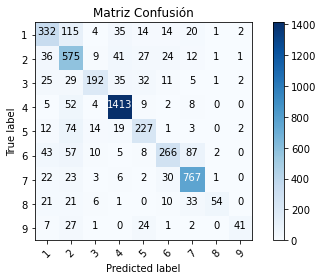

In [58]:
predictions = clf.predict(X_train)
metricas_modelos('BC-SVC-Train',y_train, predictions, [1,2,3,4,5,6,7,8,9])

In [59]:
# precisión del modelo en datos de evaluación.
print("Exactitud entranamiento: {0: .2f}".format(
        clf.score(X_train, y_train)))

Exactitud entranamiento:  0.77


-----Métricas------
Número de muestras clasificadas correctamente: 1543
Exactitud: 0.7166744078030655
Balance Accuracy score: 0.5763418759093447
Precision: 0.7220651293424167
Exhaustividad: 0.7166744078030655
F1: 0.7101217108321031
-------------------
              precision    recall  f1-score   support

           1       0.57      0.58      0.57       230
           2       0.55      0.74      0.63       311
           3       0.60      0.39      0.47       142
           4       0.90      0.93      0.91       640
           5       0.54      0.56      0.55       151
           6       0.61      0.50      0.55       206
           7       0.81      0.84      0.83       366
           8       0.89      0.38      0.53        63
           9       0.71      0.27      0.39        44

    accuracy                           0.72      2153
   macro avg       0.69      0.58      0.60      2153
weighted avg       0.72      0.72      0.71      2153



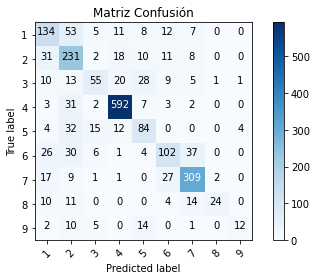

In [60]:
predictions = clf.predict(X_test)
metricas_modelos('BC-SVC-Test',y_test, predictions, [1,2,3,4,5,6,7,8,9])

In [61]:
# precisión del modelo en datos de evaluación.
print("Exactitud test: {0: .2f}".format(
        clf.score(X_test, y_test)))

Exactitud test:  0.72


#### Model Ensembles: Boosting Classifier (Ada Boost)

In [62]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5).fit(X_train, y_train)

-----Métricas------
Número de muestras clasificadas correctamente: 4395
Exactitud: 0.8753236407090221
Balance Accuracy score: 0.8581769499282396
Precision: 0.877794577005661
Exhaustividad: 0.8753236407090221
F1: 0.8757183585812246
-------------------
              precision    recall  f1-score   support

           1       0.81      0.82      0.81       537
           2       0.78      0.85      0.81       726
           3       0.90      0.84      0.87       332
           4       0.93      0.91      0.92      1493
           5       0.83      0.86      0.84       352
           6       0.85      0.79      0.82       478
           7       0.91      0.94      0.93       854
           8       1.00      0.80      0.89       146
           9       1.00      0.90      0.95       103

    accuracy                           0.88      5021
   macro avg       0.89      0.86      0.87      5021
weighted avg       0.88      0.88      0.88      5021



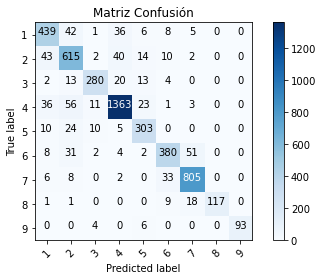

In [63]:
predictions = ada_clf.predict(X_train)
metricas_modelos('BC-AB-Train',y_train, predictions, [1,2,3,4,5,6,7,8,9])

In [64]:
# precisión del modelo en datos de evaluación.
print("Exactitud entranamiento: {0: .2f}".format(
        ada_clf.score(X_train, y_train)))

Exactitud entranamiento:  0.88


-----Métricas------
Número de muestras clasificadas correctamente: 1352
Exactitud: 0.6279609846725499
Balance Accuracy score: 0.4687091191540263
Precision: 0.6616651486289948
Exhaustividad: 0.6279609846725499
F1: 0.6233349492138809
-------------------
              precision    recall  f1-score   support

           1       0.46      0.53      0.49       230
           2       0.44      0.72      0.55       311
           3       0.49      0.35      0.40       142
           4       0.88      0.81      0.84       640
           5       0.46      0.42      0.44       151
           6       0.45      0.44      0.45       206
           7       0.81      0.76      0.78       366
           8       0.78      0.11      0.19        63
           9       1.00      0.09      0.17        44

    accuracy                           0.63      2153
   macro avg       0.64      0.47      0.48      2153
weighted avg       0.66      0.63      0.62      2153



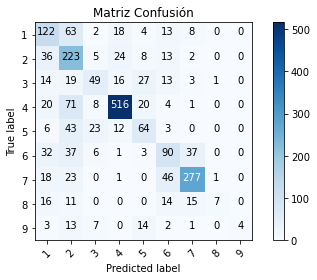

In [65]:
predictions = ada_clf.predict(X_test)
metricas_modelos('BC-AB-Test',y_test, predictions, [1,2,3,4,5,6,7,8,9])

In [66]:
# precisión del modelo en datos de evaluación.
print("Exactitud test: {0: .2f}".format(
        ada_clf.score(X_test, y_test)))

Exactitud test:  0.63


# PENDIENTEEEEEEEEEEEEEEEEEEEEE

In [ ]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
  df.drop(['field_id','label'], axis=1),
  df['label'],
  test_size=0.3,
  random_state=42,
  shuffle=True,
  stratify=df['label']
)

In [ ]:
random_state = 42
leaf_nodes = 5
num_features = 10
num_estimators = 100
numerical_features = X_train.columns.tolist()
# Decision tree for bagging
tree_clf = DecisionTreeClassifier(
  splitter='random',
  max_leaf_nodes=leaf_nodes,
  random_state=random_state
)
# Initialize the bagging classifier
bag_clf = BaggingClassifier(
  tree_clf,
  n_estimators=num_estimators,
  max_samples=1.0,
  max_features=1.0,
  random_state=random_state,
  n_jobs=-1
)
# Create a pipeline
pipe = Pipeline([
  ('preproc', PreprocessTransformer(numerical_features)),
  ('fs', SelectKBest()),
  ('clf', DecisionTreeClassifier())
])

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf': [DecisionTreeClassifier()],
    'clf__max_leaf_nodes': [128],
    'clf__max_depth':[4,5,6],
    'fs__score_func': [chi2],
    'fs__k': [200],
  },
  {
    'clf': [RandomForestClassifier()],
    'clf__n_estimators': [200],
    'clf__max_leaf_nodes': [128],
    'clf__bootstrap': [False, True],
    'clf__max_depth':[5,6],
    'fs__score_func': [chi2],
    'fs__k': [200],
  }
]
# Define scoring
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
# Define cross validation
kfold = KFold(n_splits=100)#random_state=42
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
model = grid.fit(X_train, y_train)

In [ ]:
grid.cv_results_

In [ ]:
best_estimator = grid.best_estimator_.steps[-1][1]
columns = X_test.columns.tolist()
print('Feature Importances')
                             
for i, imp in enumerate(best_estimator.feature_importances_):
  print('{}: {:.3f}'.format(columns[i], imp))

In [ ]:
print('Mean Test Accuracy',grid.cv_results_['mean_test_Accuracy'],'\n')
print('Mean Test AUC',grid.cv_results_['mean_test_AUC'],'\n')
print('Parameters Best Model',grid.cv_results_['params'])

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_estimator_.steps[-1][1]

### Conclusión

In [68]:
prec_global = [model_rf.score(X_test, y_test), 
               clf.score(X_test, y_test),
              ada_clf.score(X_test, y_test),]
prec_global, type(prec_global)

([0.6358569437993498, 0.7166744078030655, 0.6279609846725499], list)

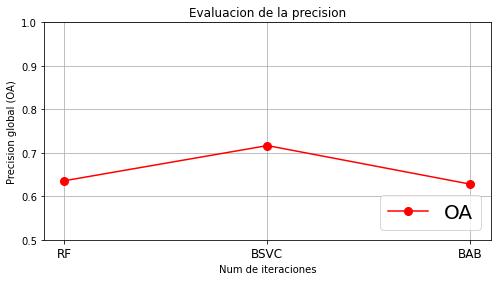

In [69]:
x = [1,2,3]
labels = ['RF', 'BSVC','BAB']

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x, prec_global, marker = 'o', ms = 8, color="red", label="OA")
ax.set_xticks(x) 
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel("Precision global (OA)")
ax.set_xlabel("Num de iteraciones")
ax.set_ylim(bottom=0.5, top=1)
ax.set_title("Evaluacion de la precision")
ax.grid(True)
ax.legend(loc="lower right", fontsize=20);

In [70]:
resultados=pd.DataFrame({'Modelo':l_modelo,'Exactitud': l_exactitud, 'Exactitud Bal.': l_bexactitud,
             'Precisión':l_precision,'Exhaustividad': l_exhaustividad, 'F1': l_f1})

In [71]:
resultados.round(2)

,Modelo,Exactitud,Exactitud Bal.,Precisión,Exhaustividad,F1
0,RF-Train,64.51,42.73,61.73,64.51,60.10
1,RF-Test,63.59,41.71,58.77,63.59,58.88
2,BC-SVC-Train,77.02,64.47,77.83,77.02,76.44
3,BC-SVC-Test,71.67,57.63,72.21,71.67,71.01
4,BC-AB-Train,87.53,85.82,87.78,87.53,87.57
5,BC-AB-Test,62.80,46.87,66.17,62.80,62.33


In [ ]:
#calculo PCa Manual
from numpy import mean
from numpy import cov
from numpy.linalg import eig
# define a matrix
A = np.array([[1, 2], [3, 4], [5, 6]])
print(A)
# calculate the mean of each column
M = mean(A.T, axis=1)
print(M)
# center columns by subtracting column means
C = A - M
print(C)
# calculate covariance matrix of centered matrix
V = cov(C.T)
print(V)
# eigendecomposition of covariance matrix
values, vectors = eig(V)
print(vectors)
print(values)
# project data
P = vectors.T.dot(C.T)
print(P.T)